# Draw 100000 ensemble members of FaIR

In [1]:
import json
import fair
from climateforcing.utils import check_and_download
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import matplotlib.pyplot as pl
from multiprocessing import Pool

## Define the Ghan aerosol function

This is given in the AR6 repository, but not quite in this form in FaIR.

In [2]:
def ghan(x, beta, n0, n1):
    """ERFaci logarithmic in emissions excluding nitrate.
    Named after Steve Ghan, whose 2013 simple emissions emulator is extremely useful,
    (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrd.50567),
    and can be emulated again using this very simple formula.
    Inputs
    ------
    x : obj:`numpy.array`
        Time series of aerosol emissions
    beta : float
        Scale factor linking forcing to time series
    n0 : float
        Shape factor for SO2 emissions, W m**-2 (TgSO2 yr**-1)**-1
    n1 : float
        Shape factor for BC+OC emissions, W m**-2 (TgC yr**-1)**-1
    Returns
    -------
    res : obj:`numpy.array`
        Time series of ERFaci
    """
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

## Download pre-prepared files from AR6

In [3]:
# get the random seeds used in AR6
check_and_download("https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_input/random_seeds.json", "../data_input/random_seeds.json")

In [4]:
# get two layer model tunings used in AR6
check_and_download(
    "https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_input/tunings/cmip6_twolayer_tuning_params.json",
    "../data_input/cmip6_twolayer_tuning_params.json"
)

In [5]:
# aerosol tunings to CMIP6 models
check_and_download(
    "https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_input/tunings/cmip6_aerosol_coefficients.json",
    "../data_input/cmip6_aerosol_coefficients.json"
)

In [6]:
# Balancing CH4 and N2O
check_and_download(
    "https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_output/fair_wg3_natural_ch4_n2o.csv",
    "../data_input/fair_wg3_natural_ch4_n2o.csv"
)

In [7]:
# Solar
check_and_download(
    "https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_output/solar_erf.csv",
    "../data_input/solar_erf.csv"
)

In [8]:
# Volcanic
check_and_download(
    "https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_output/volcanic_erf.csv",
    "../data_input/volcanic_erf.csv"
)

In [9]:
# rcmip emissions files
check_and_download(
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv',
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv'
)

In [10]:
# Ozone fits
check_and_download(
    'https://raw.githubusercontent.com/chrisroadmap/ar6/main/data_input/tunings/cmip6_ozone_skeie_fits.csv',
    '../data_input/cmip6_ozone_skeie_fits.csv'
)

## Ensemble generation

We follow similar lines to AR6, but with a smaller ensemble (= time)

In [11]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [12]:
SAMPLES = 100000
F2XCO2_MEAN = 3.93
F2XCO2_NINETY = 0.47
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

### Climate response

In [13]:
with open("../data_input/cmip6_twolayer_tuning_params.json", "r") as read_file:
    params = json.load(read_file)
cmip6_models = list(params['q4x']['model_data']['EBM-epsilon'].keys())
cmip6_models
NMODELS = len(cmip6_models)

geoff_data = np.zeros((NMODELS, 6))
for im, model in enumerate(cmip6_models):
    geoff_data[im,0] = params['q4x']['model_data']['EBM-epsilon'][model]
    geoff_data[im,1] = params['lamg']['model_data']['EBM-epsilon'][model]
    geoff_data[im,2] = params['cmix']['model_data']['EBM-epsilon'][model]
    geoff_data[im,3] = params['cdeep']['model_data']['EBM-epsilon'][model]
    geoff_data[im,4] = params['gamma_2l']['model_data']['EBM-epsilon'][model]
    geoff_data[im,5] = params['eff']['model_data']['EBM-epsilon'][model]

geoff_df = pd.DataFrame(geoff_data, columns=['q4x','lamg','cmix','cdeep','gamma_2l','eff'], index=cmip6_models)
kde = st.gaussian_kde(geoff_df.T)
geoff_sample = kde.resample(size=int(SAMPLES*1.25), seed = SEEDS[15])

# remove unphysical combinations
geoff_sample[:,geoff_sample[0,:] <= 0] = np.nan
geoff_sample[1, :] = st.truncnorm.rvs(-2, 2, loc=-4/3, scale=0.5, size=int(SAMPLES*1.25), random_state=SEEDS[16])
geoff_sample[:,geoff_sample[2,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[3,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[4,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[5,:] <= 0] = np.nan

mask = np.all(np.isnan(geoff_sample), axis=0)
geoff_sample = geoff_sample[:,~mask][:,:SAMPLES]
geoff_sample_df=pd.DataFrame(data=geoff_sample.T, columns=['q4x','lamg','cmix','cdeep','gamma_2l','eff'])
geoff_sample_df.to_csv('../data_output/geoff_sample.csv')
geoff_sample_df

f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[73])

ecs = -f2x/geoff_sample[1,:]
tcr = f2x/(-geoff_sample[1,:] + geoff_sample[4,:]*geoff_sample[5,:])

### Forcing uncertainties

In [14]:
# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

NORMALS = len(unc_ranges)

scale_normals = st.norm.rvs(
    size=(SAMPLES,NORMALS),
    loc=np.ones((SAMPLES,NORMALS)),
    scale=np.ones((SAMPLES, NORMALS)) * unc_ranges[None,:],
    random_state=SEEDS[4]
)

## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale_normals[scale_normals[:,7]<1,7] = 0.08/0.1*(scale_normals[scale_normals[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale_normals[scale_normals[:,6]<1,6] = 0.0384/0.0406*(scale_normals[scale_normals[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=SAMPLES, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=SEEDS[50])

In [15]:
with open("../data_input/cmip6_aerosol_coefficients.json") as json_file:
    cmip6_aerosol_data = json.load(json_file)

In [16]:
cmip6_aci = np.zeros((11, 2))
for i, model in enumerate(['CanESM5', 'E3SM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']):
    for j, species in enumerate(['n0','n1']):
        cmip6_aci[i,j] = np.log(cmip6_aerosol_data[model]['ERFaci'][species])
kde = st.gaussian_kde(cmip6_aci.T)
aci_coeffs=np.exp(kde.resample(size=int(SAMPLES), seed=SEEDS[8]).T)

In [17]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[97])
nit_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[98])

In [18]:
# Get SSP historical emissions
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
species = [
    'Emissions|Sulfur',
    'Emissions|BC',
    'Emissions|OC',
    'Emissions|NH3',
    'Emissions|NOx'
]

unit_convert = np.ones(5)
unit_convert[0] = 32/64 # follow zeb exactly, but would be better to use fair.constants.molwt
unit_convert[4] = 14/46

emissions_out = np.zeros((351,5))

years_future = [2015] + list(range(2020,2101,10))
for i, specie in enumerate(species):
    emissions_out[:265,i] = ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable']==specie),
        '1750':'2014']*unit_convert[i]
    f = interp1d(years_future, ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable']==specie),'2015':'2100'
    ].dropna(axis=1))
    emissions_out[265:, i] = f(np.arange(2015, 2101))*unit_convert[i]

### put together aerosol forcing

In [19]:
beta_bc = bc_20101750/(np.mean(emissions_out[255:265,1])-emissions_out[0,1])
beta_oc = oc_20101750/(np.mean(emissions_out[255:265,2])-emissions_out[0,2])
beta_so2 = so2_20101750/(np.mean(emissions_out[255:265,0])-emissions_out[0,0])
beta_nh3 = nit_20101750/(np.mean(emissions_out[255:265,3])-emissions_out[0,3])

In [20]:
ERFari = np.zeros((351, SAMPLES))
for i in range(SAMPLES):
    ERFari[:, i] = (
        (emissions_out[:,0]-emissions_out[0,0]) * beta_so2[i] +
        (emissions_out[:,1]-emissions_out[0,1]) * beta_bc[i] +
        (emissions_out[:,2]-emissions_out[0,2]) * beta_oc[i] +
        (emissions_out[:,3]-emissions_out[0,3]) * beta_nh3[i] 
    )

In [21]:
ERFaci_scale = st.norm.rvs(size=SAMPLES, loc=-1.0, scale=0.7/NINETY_TO_ONESIGMA, random_state=SEEDS[9])

In [22]:
ERFaci = np.zeros((351, SAMPLES))
beta   = np.zeros(SAMPLES)

for i in tqdm(range(SAMPLES)):
    forcing2010 = np.mean(
        ghan([
            emissions_out[255:265,0], emissions_out[255:265,1]+emissions_out[255:265,2]
        ], 0.97, aci_coeffs[i,0], aci_coeffs[i,1])
    )
    forcing1750 = ghan([emissions_out[0,0], emissions_out[0,1]+emissions_out[0,2]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1])
    ERFaci[:,i] = (ghan([emissions_out[:,0], emissions_out[:,1]+emissions_out[:,2]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) - forcing1750)/(forcing2010-forcing1750)*(ERFaci_scale[i])
    beta[i] = ERFaci_scale[i]/(forcing2010-forcing1750)

  0%|          | 0/100000 [00:00<?, ?it/s]

## Carbon cycle parameters

Uniform distributions from Leach et al 2020 https://gmd.copernicus.org/preprints/gmd-2020-390/, using full range of CMIP6 tunings.

Pre-industrial CO2 concentration uncertainty is from Jinho Ahn, chapter 2 AR6 WG1.

In [23]:
r0 = st.uniform.rvs(loc=27.7, scale=41.3-27.7, random_state=SEEDS[10], size=SAMPLES)
rC = st.uniform.rvs(loc=-0.00712, scale=0.0482+0.00712, random_state=SEEDS[11], size=SAMPLES)
rT = st.uniform.rvs(loc=-0.0847, scale=4.52+0.0847, random_state=SEEDS[12], size=SAMPLES)
pre_ind_co2 = st.norm.rvs(loc=277.147, scale=2.9, random_state=SEEDS[13], size=SAMPLES)

## We have everything we need to run FaIR with

In [24]:
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750,2101)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2100
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}

scens = ['ssp245']
for scen in scens:
    data_out[scen] = np.ones((351, 40)) * np.nan
    data_out[scen][:,0] = years

    years_future = [2015] + list(range(2020,2101,10))
    for i, specie in enumerate(species):
        data_out[scen][:first_row,i+1] = ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2100'].dropna(axis=1))
        data_out[scen][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [25]:
# add in natural emissions and natural forcing
ch4_n2o_df = pd.read_csv('../data_input/fair_wg3_natural_ch4_n2o.csv')
ch4_n2o = ch4_n2o_df.values[:351,1:]

df = pd.read_csv('../data_input/solar_erf.csv', index_col='year')
solar_forcing = df.solar_erf.loc[1750:2100].values

df = pd.read_csv('../data_input/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((351))
volcanic_forcing[:269] = df.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[268:279] = volcanic_forcing[268] * np.linspace(1,0,11)
volcanic_forcing[279:] = 0.

In [26]:
o3_df = pd.read_csv('../data_input/cmip6_ozone_skeie_fits.csv', index_col=0)

In [27]:
ozone_feedback = st.norm.rvs(loc=-0.037, scale=0.012, size=SAMPLES, random_state=SEEDS[51])

# these coefficients are Skeie fits
beta_ch4 = st.norm.rvs(loc=o3_df.loc['CH4','mean'], scale=o3_df.loc['CH4','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[52])
beta_n2o = st.norm.rvs(loc=o3_df.loc['N2O','mean'], scale=o3_df.loc['N2O','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[53])
beta_ods = st.norm.rvs(loc=o3_df.loc['ODS','mean'], scale=-o3_df.loc['ODS','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[54])
beta_co = st.norm.rvs(loc=o3_df.loc['CO','mean'], scale=o3_df.loc['CO','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[55])
beta_voc = st.norm.rvs(loc=o3_df.loc['VOC','mean'], scale=o3_df.loc['VOC','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[56])
beta_nox = st.norm.rvs(loc=46/14*o3_df.loc['NOx','mean'], scale=46/14*o3_df.loc['NOx','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[57])

In [28]:
aCO2land = -0.2 / 190
E_ref_BC = 6.095

In [29]:
scen='ssp245'
E_pi=np.zeros(40)
# unit convert not necessary as this has been done going in
E_pi[5]=1.22002422
E_pi[6]=348.527359
E_pi[7]=60.0218262
E_pi[8]=3.87593407
E_pi[9]=2.09777075
E_pi[10]=15.4476682
E_pi[11]=6.92769009

aCO2land = -0.2 / 190
E_ref_BC = 6.095

arglist = []
for i in tqdm(range(SAMPLES)):
    # should we use RCMIP or AR6 values??
    # do not move this out of the loop
    C_pi=np.zeros(31)
    C_pi[0] = pre_ind_co2[i]
    C_pi[1]=731.406
    C_pi[2]=273.8651
    C_pi[3]=34.05
    C_pi[4] = 32.28077001      # where did this come from? 
    C_pi[25]=0.00434894
    C_pi[29]=8.75191031
    C_pi[30]=755.7838942
    scale = np.ones(45)
    scale[1] = scale_normals[i,1] * 0.86 # methane adjustment
    scale[2] = scale_normals[i,2] * 1.07
    scale[3:31] = scale_normals[i,3]
    scale[15] = scale_normals[i,3] * 1.13 # cfc11 adjustment
    scale[16] = scale_normals[i,3] * 1.12 # cfc12 adjustment
    #scale[31] = scale_normals[i,4]
    scale[33:35] = scale_normals[i,5:7]
    scale[41:44] = scale_normals[i,7:10]
    F_solar = np.zeros(351)
    F_solar[:270] = np.linspace(0,trend_solar[i],270) + solar_forcing[:270]*scale_normals[i,10]
    F_solar[270:351] = trend_solar[i] + solar_forcing[270:351]*scale_normals[i,10]
    arglist.append(
        {
            'ghg_forcing': 'Meinshausen',
            'emissions': data_out[scen],
            'natural': ch4_n2o,
            'F_volcanic': volcanic_forcing,
            'F_solar': solar_forcing,
            'efficacy': np.ones(45),
            'diagnostics': 'AR6',
            'gir_carbon_cycle': True,
            'aerosol_forcing': 'aerocom+ghan2',
            'fixPre1850RCP': False,
            'E_pi': E_pi,
            'temperature_function': 'Geoffroy',
            'b_tro3': np.array([beta_ch4[i], beta_n2o[i], beta_ods[i], beta_co[i], beta_voc[i], beta_nox[i]]),
            'ozone_feedback': ozone_feedback[i],
            'tropO3_forcing': 'thornhill-skeie',
            'aCO2land': aCO2land,
            'stwv_from_ch4': 0.079047,
            'F_ref_BC': 0.08,
            'E_ref_BC': E_ref_BC,
            'C_pi': C_pi,
            'F2x': f2x[i],
            'r0': r0[i],
            'rc': rC[i],
            'rt': rT[i],
            'lambda_global': -geoff_sample_df.loc[i, 'lamg'],  # this and the below only used in two-layer model
            'ocean_heat_capacity': np.array([geoff_sample_df.loc[i, 'cmix'], geoff_sample_df.loc[i, 'cdeep']]),
            'ocean_heat_exchange': geoff_sample_df.loc[i, 'gamma_2l'],
            'deep_ocean_efficacy': geoff_sample_df.loc[i, 'eff'],
            'b_aero': np.array([beta_so2[i], 0.0, 0.0, 0.0, beta_bc[i], beta_oc[i], beta_nh3[i]]),
            'ghan_params': np.array([beta[i], aci_coeffs[i,0], aci_coeffs[i,1]]),
            'scale': scale,
        }
    )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [30]:
def run_fair(args):
    thisC, _, thisT, _, thisOHU, _, _ = fair.forward.fair_scm(**args)
    return (
        thisC[:,0], 
        thisT,
        thisOHU,
    )

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, arglist), total=SAMPLES))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [31]:
result_t = np.array(result).transpose(1,2,0)

In [32]:
C_CO2, T, OHU = result_t

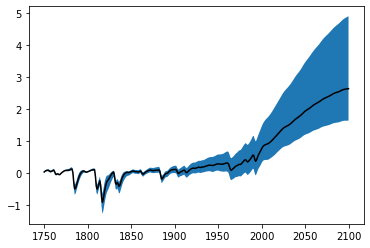

In [33]:
pl.fill_between(np.arange(1750,2101), np.percentile(T, 5, axis=1), np.percentile(T, 95, axis=1))
pl.plot(np.arange(1750,2101), np.percentile(T, 50, axis=1), color='k')

## Save unconstrained output

In [34]:
np.save('../data_output_large/C_CO2_unconstrained.npy', C_CO2)
np.save('../data_output_large/T_unconstrained.npy', T)
np.save('../data_output_large/OHU_unconstrained.npy', OHU)